In [1]:
import os
import time
import sys
import copy
import bisect
import pickle

import cv2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from skimage import transform

from scipy import stats
import scipy.signal as signal
import scipy.interpolate as interpolate
from scipy import ndimage as nd

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import TheilSenRegressor
from skimage import transform
from tqdm.notebook import tqdm

import isx

In [2]:
def get_background_images(in_movie, seg_times, n_background_frames = 500, fps = 20):
    #
    # 
    #
    #
    #
    
    print('Background detection assuming {}fps video\n'.format(fps))
    
    rng = np.random.default_rng()
    
    vid = cv2.VideoCapture(in_movie)
    num_frames = int(vid.get(cv2.CAP_PROP_FRAME_COUNT))
    vid_size = [int(vid.get(4)), int(vid.get(3))]
    
    # convert segments to indices and add start/stop frames:
    seg_times = [int(i*fps) for i in seg_times]
    seg_times.append(num_frames)
    seg_times.insert(0, 0)
    seg_idx = [[i, j] for i,j in zip(seg_times[:-1], seg_times[1:]) ]
    
    out_list = []
    
    # build background image for each segment:
    for seg in tqdm(seg_idx):
        framevect = np.unique(rng.integers(seg[0], seg[1], int(n_background_frames * 2)))[:n_background_frames] # draw n_background_frames without replacement
        background_dat = np.zeros( (len(framevect), vid_size[0], vid_size[1]) ).astype('uint8')
        #vid = cv2.VideoCapture(vid_fn)
        #bidx = 0
        for bidx,i in enumerate(framevect):
            vid.set(1, i)
            theframe = vid.read()[1]
            grayscale = cv2.cvtColor(theframe,cv2.COLOR_BGR2GRAY).astype('uint8')
            #grayscale = (np.sum(theframe,axis=2)/3).astype('uint8')
            background_dat[bidx] = grayscale
            #bidx += 1        

        #background_frame = np.median(background_dat, axis=0)
        out_list.append(np.median(background_dat, axis=0))
        

    
    vid.release()
    return out_list

###################################################################################
###################################################################################

def movie_com(in_movie, background_movie, seg_times, filt_size = 10, ds_fact = 4, pthresh = 99, fps = 20):
    #
    #
    #

    vid = cv2.VideoCapture(in_movie)
    num_frames = int(vid.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_range = list(range(num_frames))

    # initialize output:
    com_vect = np.zeros((len(frame_range),2)).astype('int32')
    
    seg_times = [int(i*fps) for i in seg_times]
    seg_times.append(num_frames)
    seg_times.insert(0, 0)
    seg_idx = [[i, j] for i,j in zip(seg_times[:-1], seg_times[1:]) ]
    
    movie_epochs = [np.arange(i[0],i[1]) for i in seg_idx]
    print(np.shape(movie_epochs))

    for framei in tqdm(range(len(frame_range))):
        vid.set(1, framei)
        theframe = vid.read()[1]

        background_frame_ds = transform.downscale_local_mean(background_movie[np.argwhere([framei in i for i in movie_epochs])[0][0]], (ds_fact, ds_fact))
        grayscale = transform.downscale_local_mean( cv2.cvtColor(theframe,cv2.COLOR_BGR2GRAY).astype('uint8'), (ds_fact,ds_fact))

        bg_subtracted = grayscale - background_frame_ds
        bg_subtracted[bg_subtracted > np.percentile(bg_subtracted, 100-pthresh)] = 0
        bg_subtracted[bg_subtracted > 0] = 255

        center_of_mass = nd.center_of_mass(nd.maximum_filter(bg_subtracted, int(filt_size / ds_fact )))
        
        if sum(np.isnan(center_of_mass)):
            com_vect[framei] = com_vect[framei -1]
        else:
            com_vect[framei] = [i for i in center_of_mass]

    vid.release()
    return com_vect

###################################################################################
###################################################################################


    


In [3]:
def apply_butterworth(sig,cutoff,fs,filt_order,filt_type):
    #
    # applies zero-phase digital butterworth filter to data in sig
    # if sig is a matrix, data in its columns are filtered
    #
    # cutoff is filter's critical frequency in Hz, or n=2 tuple of freqs for bandpass filters
    # fs is sampling rate
    # filt_order is integer filter order
    # filt_type is 'lowpass','highpass', 'bandpass', or 'bandstop' 
    # 
    # returns filtered signal 
    #
    
    nyq = 0.5 * fs
    norm_cutoff =cutoff/nyq
    b,a = signal.butter(filt_order,norm_cutoff,btype=filt_type,analog=False)
    
    if sig.ndim > 1:
        filt_sig = signal.filtfilt(b,a,sig,axis=1)
    elif sig.ndim == 1:
        filt_sig = signal.filtfilt(b,a,sig)
    else:
        filt_sig = []
    
    return filt_sig

def median_filter_matrix(inmtx,winsize=3):
    #
    # median filters each column of matrix with kernal width = winsize
    #
    # returns filtered matrix
    #
    
    filtmtx = np.zeros_like(inmtx)
    
    for i in range(inmtx.shape[0]):
        filtmtx[i] = signal.medfilt(inmtx[i],winsize)
    return filtmtx

def otsu(x):
    # returns threshold estimated via Otsu's method
    # x needs to be 1-d list
    nbins = 500
    logx = np.log(x)
    logx = np.asarray([i for i in logx if np.isfinite(i)])
    
    minim = min(logx)
    maxim = max(logx)
    logx = (logx-minim)/(maxim-minim)
    
    xhist = np.histogram(logx, bins=nbins)
    xbins = xhist[1]
    xbins = xbins[1:]
    xcounts = xhist[0] / sum(xhist[0])

    maximum = 0
    thresh = 0
    
    for t in range(len(xcounts)):
        w0 = sum(xcounts[:t])
        w1 = sum(xcounts) - w0
        if w0 == 0 or w1 == 0:
            #print('continuing...')
            continue
        mu0 = sum(xbins[:t]*xcounts[:t]) / w0
        mu1 = sum(xbins[t:]*xcounts[t:]) / w1
        sigB = w0 * w1 * ((mu0 - mu1) * (mu0 - mu1))
        if sigB >= maximum:
            maximum = sigB
            thresh = xbins[t]
    
    th = thresh*(maxim-minim) + minim
    th = np.exp(th)
    #th = np.power(10,th)
    thresh = th

    return thresh


def register_signals(ref_time,in_dat,in_time):
    #
    # Direct alignment of signals that were sampled at diffrent rates
    # resamples in_dat to len(ref_time) by aligning timestamps in ref_time with timestamps in in_time
    # in_time is vector of timestamps for data in in_dat
    #
    # len(ref_time) < len(in_time)
    #
    #
    
    resamp_dat = np.zeros_like(ref_time)

    for t in range(len(ref_time)):
        dat = in_dat[bisect.bisect(in_time,ref_time[t])-1]
        resamp_dat[t] = dat
    return resamp_dat
    
def segment(x,thresh):
    # returns onsets & offset indices of impulses that exceed thresh in vector x
    xsub = x - thresh
    xdiff = (xsub[:-1]*xsub[1:]) < 0
    edges = np.where(xdiff == 1) # indices at onsets/offsets
    edges = list(edges[0])
    
    x[0:5] = 0
    
    if np.mean(np.diff(x[edges[0]-2:edges[0]+2])) < 0: # delete first impulse if offset
        print('first impulse is offset')
        edges.pop(0)
    if np.mean(np.diff(x[edges[-1]-2:edges[-1]+2])) > 0: # delete last impulse if onset
        print('last impulse is onset')
        edges.pop(-1)
    onsets = edges[0::2]
    offsets = edges[1::2]
    
    if len(onsets) > len(offsets):
        onsets.pop(-1)
    
    return [onsets,offsets]

def extractsegments(x,onsets,offsets,win):
    # returns list of slices from x[onsets[i]-win:offsets[i]+win]
    
    win = int(win)
    if onsets[0] - win < 1 or offsets[-1] > len(x):
        print('Edge Syllable')
        return []
    else:
        segs = [x[onsets[i]-win : offsets[i]+win] for i in range(len(onsets))]
        return segs
    
def filtersegments(segs,minlen,maxlen):
    # deletes elements of segs with maxlen < len() < minlen
    return [i for i in segs if len(i) > minlen and len(i) < maxlen]
    
def twoaxis(axname,lwidth=2):
    #
    # formats axes by setting axis thickness & ticks to lwidth and clearing top/right axes
    #
    #
    axname.spines['bottom'].set_linewidth(lwidth)
    axname.tick_params(width=lwidth)
    axname.spines['left'].set_linewidth(lwidth)
    axname.spines['top'].set_linewidth(0)
    axname.spines['right'].set_linewidth(0)
    
# functions for object detection:

def subtract_img_background(input_img):
    #
    # Uses pixel dilation to adaptively filter nonuniform background from objects in input_img
    #
    # input image is NxM  matrix of pixel intensities 
    #
    # returns filtered image.
    #
    # Adapted from skimage 'Filtering regional maxima'. Requires : 
    # import numpy as np
    # import matplotlib.pyplot as plt
    # from scipy.ndimage import gaussian_filter
    # from skimage.filters import threshold_otsu
    # #from skimage import img_as_float
    # from skimage.morphology import reconstruction
    #
    #
    img = img_as_float(input_img)
    img_g = gaussian_filter(img,1)

    h = threshold_otsu(img_g)

    seed = img_g - h
    mask = img_g

    dilated = reconstruction(seed,mask,method='dilation')

    return img_g-dilated

def norm_image(in_img):
    #
    # returns in_img normalized to [0-255]
    #
    #
    
    i_min = np.min(in_img)
    i_max = np.max(in_img)
    
    norm_img = 255 * ((in_img + abs(i_min) / i_max))
    
    return norm_img

def estimate_num_cells(in_img):
    #
    # Estimates number of gaussian-like blobs in in_img using laplacian of gaussians (LoG)
    #
    # 
    # in_img is NxM matrix of pixel intensities
    # in_img is probably maximum or other projection of motion corrected or df/f movie
    #
    # requires skimage.feature.blob_log()
    #
    # returns N x 3 matrix, N=num_blobs, out[0] = y coordinates, out[1] = x coordinates, out[2] = blob radius 
    #
    
    # log_params:
    min_sigma = 2
    max_sigma = 20
    num_sigma = int((max_sigma-min_sigma))
    threshold = 1
    overlap =0.1
    
    img_background_subtract = subtract_img_background(in_img)
    img_norm = norm_image(img_background_subtract)
    objs = blob_log(img_norm,min_sigma = min_sigma,max_sigma=max_sigma,num_sigma=num_sigma,threshold=threshold,overlap=overlap)
    
    return objs


In [4]:
def count_nans(indat):
    #
    # returns the number of NaN values in indat
    # 
    
    return np.isnan(indat).sum()

def events_to_raster(event_times,timing,smooth_win=0):
    #
    # returns raster and length vector of event_times, optionally smoothed with gaussian of smooth_win number of pnts
    #
    # timing is <class 'isx.core.Timing'> from EventSet
    #
    # Example usage: offs,amps = events_1.get_cell_data(0)
    # [rast,tvect] = events_to_raster(offs,events_1.timing,0)
    # plot tvect vs rast
    #
    
    samp_vect = [i for i in range(timing.num_samples)]
    event_times_samps = event_times / timing.period.to_usecs()
    raster = np.zeros_like(samp_vect)
    if len(event_times) == 0:
        raster = [np.nan for i in raster]        
        return[raster,samp_vect]
    else:    
        raster[event_times_samps.astype(int)] = 1
    
        if smooth_win > 0:
            win = signal.gaussian(int(smooth_win)*10,smooth_win)
            raster_sm = np.convolve(raster,win,mode='same')
            raster = raster_sm
        
        return [raster,samp_vect]

def rasters_from_eventset(eventset,sm_win=0):
    #
    # returns numcell X sample matrix of rasters derived from eventset
    #
    # optionally smooths rasters with gaussian window with std deviation = sm_win samples
    #
    
    offs,amps = eventset.get_cell_data(0)
    raster,raster_x = events_to_raster(offs,eventset.timing,sm_win)
    outmtx = np.zeros([len(raster),eventset.num_cells])
    for cellnum in range(eventset.num_cells):
        offs,amps = eventset.get_cell_data(cellnum)
        raster,raster_x = events_to_raster(offs,eventset.timing,sm_win)
        outmtx[:,cellnum] = raster
    
    return outmtx
 
def traces_from_cellset(cellset,nrm=0):
    #
    # returns numcells x max(tstamps) matrix of traces from cellset
    # centers (mean subtracts) each trace if nrm==1
    #
    
    tracelen = 0
    for i in range(cellset.num_cells): # find length of traces for initialization:
        if len(cellset.get_cell_trace_data(0)) > tracelen:
            tracelen = len(cellset.get_cell_trace_data(0))
            break
    outmtx = np.zeros([tracelen,cellset.num_cells]) # init output
    for i in range(cellset.num_cells): # populate output with traces from cellsets:
        if nrm == 1 and sum(abs(cellset.get_cell_trace_data(i)))>0:
            outmtx[:,i] = cellset.get_cell_trace_data(i) - np.nanmean(cellset.get_cell_trace_data(i))
        else:    
            outmtx[:,i] = cellset.get_cell_trace_data(i)
    return outmtx

def images_from_cellset(cellset):
    #
    # returns numcells x max(tstamps) matrix of images from cellset
    #
    img = cellset.get_cell_image_data(0)
    
    outmtx = np.zeros([img.shape[0],img.shape[1],cellset.num_cells]) # init output
    for i in range(cellset.num_cells): # populate output with traces from cellsets:
        outmtx[:,:,i] = cellset.get_cell_image_data(i)
    return outmtx


def remove_nan_rows(inmtx_list):
    #
    # Detects rows with missing data points (NaNs) in each matrix in inmtx_list. Removes rows from all elements
    # of inmtx_list
    #
    
    nanrows = []
    outlist = []
    for mtx in inmtx_list:
        livecols = np.where(np.all(np.isnan(mtx),axis=0)==False)[0] # find columns that contain data
        thenanrows = np.where(np.any(np.isnan(mtx[:,livecols]),axis=1))[0] # find rows with NaNs
        nanrows.append(thenanrows)
    del_these_rows = [i for lst in nanrows for i in lst] # flattens lists in nanrows
    
    for mtx in inmtx_list:
        outmtx = np.delete(mtx,del_these_rows,axis=0)
        #outlist.append(np.delete(mtx,del_these_rows,axis=0))
        outlist.append(outmtx)
    
    return outlist

def build_trace_volume(cellset_list):
    #
    # assembles [p,l,c] matrix of traces from list of LR cellsets. p is number of planes/cellsets, l is data
    # length, c is number of cells.
    #
    # removes dropped/cropped frames from all cellsets' data
    # removes additional rows with missing data from all cellsets' data
    #
    # if traces are not equal length, crops ends to minimum length
    #
    # returns trace_matrix
    # 
    
    remove_frames = np.array([],dtype=int)
    tracemtx_list = []
    for l in cellset_list:
        cellset = isx.CellSet.read(l)
        remove_frames = np.append(remove_frames,cellset.timing.dropped)
        remove_frames = np.append(remove_frames,cellset.timing.cropped)
        tracemtx_list.append(traces_from_cellset(cellset,nrm=1))
    
    clean_list = []
    for m in tracemtx_list:
        outmtx = np.delete(m,remove_frames.flatten().astype(int),axis=0)
        clean_list.append(outmtx)    
    
    clean_list_nonan = remove_nan_rows(clean_list)
    npnts = min([len(i) for i in clean_list_nonan])
    out_list = [i[0:npnts,:] for i in clean_list_nonan]
    trace_vol = np.stack(out_list,axis=0)
    
    return trace_vol

def build_img_volume(cellset_list):
    #
    # assembles [p,x,y,c] matrix of images from list of LR cellsets. p is number of planes/cellsets, l is data
    # length, c is number of cells.
    #
    # returns image matrix
    #

    mtx_list = []
    for l in cellset_list:
        cellset = isx.CellSet.read(l)
        mtx_list.append(images_from_cellset(cellset))
    
    img_vol = np.stack(mtx_list,axis=0)
    
    return img_vol

def build_raster_volume(eventset_list,sm_win=0):
    #
    # assembles [p,x,c] matrix of rasters from list of LR cellsets. p is number of planes/cellsets, x is data
    # length, c is number of cells.
    #
    # optionally smooths rasters with gaussian with std = sm_win samples 
    #
    # returns raster matrix
    #

    mtx_list = []
    for l in eventset_list:
        eventset = isx.EventSet.read(l)
        mtx_list.append(rasters_from_eventset(eventset,sm_win))
    
    rast_vol = np.stack(mtx_list,axis=0)
    
    return rast_vol
    
def find_LR_planes(inmtx):
    #
    # detects plane boundaries in Longitudinally registered matrix 
    #
    # returns list of start and stop points for each plane, e.g for 3 planes: [[0:100],[101:200],[201:300]]
    #
    
    outpnts = []
    start_p = 0
    for p in range(inmtx.shape[0]): # each plane
        if p == inmtx.shape[0]-1:
            stop_p = inmtx.shape[2]
        #elif len(np.nonzero(np.isnan(inmtx[p,0,start_p:]))):
        elif np.shape(np.nonzero(np.isnan(inmtx[p,0,start_p:])))[1]:
            print(p)
            #print(np.isnan(inmtx[p,0,start_p:]))
            print(np.shape(np.nonzero(np.isnan(inmtx[p,0,start_p:]))))
            print(np.shape(np.nonzero(np.isnan(inmtx[p,0,start_p:])))[1])
            stop_p = np.min(np.nonzero(np.isnan(inmtx[p,0,start_p:])))+start_p
        else:
            stop_p = inmtx.shape[2]
        outpnts.append([start_p,stop_p-1])
        start_p = stop_p
        
    return outpnts

def corr_dist_1d_volume(inmtx,bkpnts):
#
# returns distrubution of trace x trace correlations for signals within a plane
#
# inmtx is matrix of union cellsets with dimensions [num_planes,data_length,num_signals]
# bkpnts is array of endpoints that separate imaging planes, e.g. if bkpnts = [100,200,500],
# units IDed on plane 1 are inmtx[0,:,0:100], units IDed on plane 2 are inmtx[1,:,101:200], etc
# Bkpnts should be same length of np.shape(inmtx)[0]
#
# to call this function on first plane in matrix, use corr_dist_1d_volume(mtx[0:1,:,:])
# to call this function on second plane in matrix, use corr_dist_1d_volume(mtx[1:2,:,:]) etc
#
    corrlist = []
    
    pnt_i = 0
    startpnt = 0
    for plane in inmtx:
        subplane = plane[:,startpnt:bkpnts[pnt_i]]
        #print(np.shape(subplane),end='')
        corrmtx = (np.corrcoef(subplane,rowvar=False))
        corrs = corrmtx[np.triu_indices(corrmtx.shape[0],k=1)]
        corrlist.append(corrs)
        
        startpnt = bkpnts[pnt_i]+1
        pnt_i += 1
        
    #return np.concatenate(corrlist)
    return corrlist

def corr_dist_z_volume(inmtx,bkpnts):
#
# returns list of distrubutions of trace x trace correlations for distinct xy signals between planes.
# also returns list of indices of planes analyzed to serve as a lookup table
#
# inmtx is matrix of union cellsets with dimensions [num_planes,data_length,num_signals]
# bkpnts is array of start-endpoints that separate imaging planes, e.g. if bkpnts = [[0,100],[101,200],[201,500]],
# units IDed on plane 1 are inmtx[0,:,0:100], units IDed on plane 2 are inmtx[1,:,101:200], etc
# Bkpnts should be same length of np.shape(inmtx)[0]
#

    corrlist = []
    corrmtxlist = []
    
    plane_list = list(range(np.shape(inmtx)[0]))
    plane_combos = list(itl.combinations(plane_list,2))
    
    for f in plane_combos:
        subplane1 = inmtx[f[0],:,bkpnts[f[0]][0]:bkpnts[f[0]][1]]
        subplane2 = inmtx[f[1],:,bkpnts[f[1]][0]:bkpnts[f[1]][1]]
        mergeplane = np.concatenate([subplane1,subplane2],axis=1)
        
        corrmtx = (np.corrcoef(mergeplane,rowvar=False))        
        corrs = corrmtx[0:bkpnts[f[0]][1]-bkpnts[f[0]][0],bkpnts[f[0]][1]-bkpnts[f[0]][0]+1:len(corrmtx)]
        corrmtxlist.append(corrs)
        corrlist.append(np.ravel(corrs))
        
    return [corrlist,corrmtxlist,plane_combos]

def aligned_z_corrs(data_volume,threshs = []):
    #
    # returns distribution of z-correlations in data_volume
    # Optionally makes retain/reject decision for each element based on threshs
    #
    
    plane_list = list(range(np.shape(data_volume)[0]))
    plane_combos = list(itl.combinations(plane_list,2))
    
    datacorrs = []
    
    if len(threshs) > 0:
        decision_array = np.zeros([trace_volume.shape[2],1])
        decision_planes = [[] for i in decision_array]
        splitcorrs = []
    
    for i in range(data_volume.shape[2]): # each cell
        combo_i = 0
        for f in plane_combos: # each pairwise plane set
            #corrthresh = corr_threshs[f[0],f[1]]
            if len(threshs) > 0:
                corrthresh = corr_threshs[combo_i]
                combo_i += 1
                #print(corrthresh)
            trace1 = data_volume[f[0],:,i]
            trace2 = data_volume[f[1],:,i]
        
            if np.isnan(trace1).sum() == 0 and np.isnan(trace2).sum() == 0: # if cell has signal on multiple planes then split/merge:
                thecorr = np.corrcoef(trace1,trace2)[0][1]
                datacorrs.append(thecorr)
                if len(threshs) > 0:
                    if thecorr < corrthresh: # split cells
                        decision_array[i] = 1
                        decision_planes[i].append(f)
                        splitcorrs.append(round(thecorr,2))

    if len(threshs) > 0:
        return [datacorrs,decision_array,decision_planes,splitcorrs]
    else:
        return datacorrs
    
def write_1d_cellset(fn,trace_data,img_data,cell_names,spacing,timing):
    #
    # writes .isxd cellset file to filename = fn
    # trace_data is [n,c] shaped matrix of activity traces. n = trace length, c = number of cells
    # img_data is [x,y,c] shaped matrix of cell images. x and y = image dimensions, c = number of cells
    #
    # cell_names is list of strings to name each cell. If this is empty, cells are named sequentially.
    # 
    # spacing and timing are given by data movies and describe image size and activity (trace) sampling info
    #
    # overwrites existing cellsets with same names without warning
    #
    
    if os.path.exists(fn) is False:
        out_cellset = isx.CellSet.write(fn,timing,spacing)
    elif os.path.exists(fn) is True:
        os.remove(fn)
        out_cellset = isx.CellSet.write(fn,timing,spacing)
        
    for i in range(trace_data.shape[1]): # each cell        
        if len(cell_names) == 0:
            c_name = 'C{}'.format(i)
            
        else:
            c_name = cell_names[i]
        out_cellset.set_cell_data(i,img_data[:,:,i].astype(np.float32),trace_data[:,i].astype(np.float32),c_name)
    
    out_cellset.flush()
    
def sensitivity_precision(data_volume,winsize = 5):
    #
    # returns sensitivity and precision calcs for each element n [:,:,n] in data_volume
    #
    # data_volume[,n,:] are event traces over time (e.g. event trains / rasters)
    # data_volume[n,:,:] are reference and test sets
    #
    # winsize is integer size of window around events
    #
    
    conv_vect = np.ones((1,winsize))[0]
    
    sens = []
    prec = []
    
    for i in range(data_volume.shape[2]): # each element [:,:,i]
        ref_trace = data_volume[0,:,i]
        test_trace = data_volume[1,:,i]
        if np.isnan(ref_trace).sum() == 0 and np.isnan(test_trace).sum() == 0: # if cell has signal on both planes:
            # detected (test) events:
            sm_rast_det = np.convolve(test_trace,conv_vect,mode='same')
            sm_rast_det[sm_rast_det > 0] = 1
            det_pos_pnts = np.nonzero(sm_rast_det)[0] # points around test events
            det_neg = [i for i in range(len(ref_trace)) if i not in det_pos_pnts] # points around test negatives
            
            true_pos = (sum(ref_trace[det_pos_pnts]))
            false_pos = max([sum(test_trace) - true_pos, 0])
            false_neg = sum(ref_trace[det_neg])
            #true_neg = len([i for i in ref_neg if i in det_neg])
            
            prec.append(true_pos / (true_pos + false_pos)) # precision: fraction of correctly detected events among all detected events
            sens.append(true_pos / (true_pos + false_neg)) # sensitivity: fraction of events detected
            

    return [sens,prec] 
    
def event_detection_cnmfe(cellset, snr_thresh = 1, peak_dist = 0.25, peak_width = 0.4):
    #
    # Applies scipy.signal.findpeaks() to identify events in CNMF-E or PCA-ICA cellset traces and writes isx.Eventset
    #
    # Designed to detect events in cnmfe cellsets but also applicable to PCA-ICA cellsets
    #
    # Computes threshold for each trace as [snr_thresh * (abs(median_abs_deviation / median) * median_abs_deviation)] 
    #
    # 
    #
    
    ed_file = isx.make_output_file_path(cellset.file_path, os.path.dirname(cellset.file_path), 'ED')
    if os.path.isfile(ed_file):
        os.remove(ed_file)
    cellnames = [cellset.get_cell_name(i) for i in range(cellset.num_cells)]    
    ed_set = isx.EventSet.write(ed_file, cellset.timing, cellnames)
    
    cellset_fs = round((1 / (cellset.timing.period.to_usecs() * 1e-6) ),3)
    #print(cellset_fs)
    pdist = int(peak_dist * cellset_fs)
    pwidth = int(peak_width * cellset_fs)
    
    for i in range(cellset.num_cells):
        the_trace = cellset.get_cell_trace_data(i)

        thresh_mult = snr_thresh * abs(stats.median_absolute_deviation(the_trace) / np.median(the_trace))
        peak_thresh = thresh_mult * abs(stats.median_absolute_deviation(the_trace))        
        
        peaks = signal.find_peaks(the_trace, peak_thresh, distance= pdist, width= pwidth)[0]
        ed_set.set_cell_data(i, 1e6*(peaks/cellset_fs), the_trace[peaks])
    ed_set.flush()
    return ed_set.file_path
    
    
def cellset_qc(cellset_fn, eventset_fn, filters):
    #
    # applies conditions to accept/reject cells in cellset based on eventset
    #
    # filters format = [('SNR', '>', 5), ('Event Rate', '>', 0.0015), ('# Comps', '=', 1)]
    #
    
    cellset = isx.CellSet.read(cellset_fn,read_only=False)
    if os.path.isfile(eventset_fn):
        eventset = isx.EventSet.read(eventset_fn)
    else: 
        event_detection_cnmfe(cellset)
        eventset = isx.EventSet.read(eventset_fn)
    metric_fn = isx.make_output_file_path(cellset_fn, os.path.dirname(cellset_fn), 'METRICS')
    if os.path.isfile(metric_fn):
        os.remove(metric_fn)
    isx.cell_metrics(cellset_fn, eventset_fn, metric_fn)
    metrics_df = pd.read_csv(metric_fn)
    metrics_df.columns = [i.lower() for i in metrics_df.columns]
    
    cell_rej = []
    tmp_rej = []
    for i in filters:
        if i[0].lower() in metrics_df.columns: # identify cells that fail criterion:
            tmp_rej = []
            tmp_rej.append(metrics_df.loc[metrics_df[i[0].lower()] <= float(i[2])].index)
            #print('Checking cells {}...'.format(i[0]))
            cell_rej += tmp_rej
        else: 
            print('{} is not a valid metric.'.format(i[0]))

    os.remove(metric_fn)
    
    out_list = sorted(list(set([i for j in cell_rej for i in j])))
    accept_list = [i for i in range(cellset.num_cells) if i not in out_list]
    
    # modify cellsets:
    for i in out_list:
        cellset.set_cell_status(i,'rejected')
    for i in accept_list:
        cellset.set_cell_status(i,'accepted')    
    
    
    return out_list
    
    
def twoaxis(axname,lwidth=1.5):
    #
    # formats axes by setting axis thickness & ticks to lwidth and clearing top/right axes
    #
    #
    axname.spines['bottom'].set_linewidth(lwidth)
    axname.tick_params(width=lwidth)
    axname.spines['left'].set_linewidth(lwidth)
    axname.spines['top'].set_linewidth(0)
    axname.spines['right'].set_linewidth(0)

In [5]:
def cellset_data_volumes(cs_file, snr_thresh=2, isx_ed_threshold = 5, autosort_snr = 5):
    #
    # reads cellset specified by cs_file and returns:
    # [trace_mtx, raster_mtx, raster_mad_mtx]
    #
    # trace_mtx is [n,m] matrix of m-cells n-sample calcium signals 
    # raster_mtx is [n,m] matrix of m-cells n-sample calcium events (0-1) deteted with event_detection_cnmfe()
    # raster_mas_mtx is [n,m] matrix of m-cells n-sample calcium events (0-1) deteted with isx.event_detection()
    # 
    # returns accepted/undecided cells only
    #
    
    # read cellset:
    cellset = isx.CellSet.read(cs_file)

    # event detection:
    ed_file = isx.make_output_file_path(cs_file, os.path.dirname(cs_file), 'ED')
    if os.path.isfile(ed_file):
        os.remove(ed_file)
    event_detection_cnmfe(cellset, snr_thresh = snr_thresh, peak_dist = 0.3, peak_width = 0.2)

    # isx (MAD) event detection:
    isxed_file = isx.make_output_file_path(cs_file, os.path.dirname(cs_file), 'isxED')
    if os.path.isfile(isxed_file):
        os.remove(isxed_file)
    isx.event_detection(cs_file, isxed_file, event_time_ref='maximum', threshold=isx_ed_threshold)

    
    # build trace, raster, peak data volumes:
    trace_volume = build_trace_volume([cs_file])
    raster_volume = build_raster_volume([isx.make_output_file_path(cs_file, os.path.dirname(cs_file), 'ED')], sm_win=0)
    raster_isx_volume = build_raster_volume([isx.make_output_file_path(cs_file, os.path.dirname(cs_file), 'isxED')], sm_win=0)
    #peak_volume = (raster_volume*trace_volume) # rasters with scalar event sizes
    #peak_isx_volume = (raster_isx_volume*trace_volume)
    #ref_volume = np.copy(trace_volume)
    #ref_volume[10:,0] = signal.medfilt(ref_volume[:-10,0],7)

    # get length of recording:
    #max_t = (isx.Duration.to_usecs(cellset.timing.period)*1e-6) * cellset.timing.num_samples
    
    # auto accept/reject:
    isx.auto_accept_reject(cs_file, isxed_file, filters = [('# Comps', '=', 1), ('Event Rate', '>', 0), ('SNR', '>', autosort_snr)])
    

    # create mask for excluding rejected cells:
    cell_mask = np.ones((cellset.num_cells))
    #print(cellset.num_cells)
    for i in range(cellset.num_cells):
        if cellset.get_cell_status(i) == 'rejected':
            cell_mask[i] = 0

    accepted_cells = np.nonzero(cell_mask)[0]
    
    return [trace_volume[0][:,accepted_cells], raster_volume[0][:,accepted_cells], raster_isx_volume[0][:,accepted_cells]]



In [6]:
def get_cellset_paths(df):
    '''
    get_cellset_paths(df, col_dict = {})
    
    INPUTS:
    df <pandas dataframe>: must have these columns: 'data_dir_ca', 'isxd_data_basename'
    
    OUTPUTS:
    out_list <list>: list of isxd cellsets meeting conditions in col_dict
    
    '''
    
    out_list = []
    
    for pathname,filename in zip(df.data_dir_ca.values, df.isxd_data_basename.values):
        pathname = fix_data_path(pathname)
        if os.path.isdir(pathname):
            if len([i for i in os.listdir(pathname) if 'pcaica.isxd' in i]): # check base directory for pcaica.isxd cellset
                cellset_fn = pathname + [i for i in os.listdir(pathname) if 'pcaica.isxd' in i][0]
                out_list.append(cellset_fn)
            else: # check for pipeline directory
                if len([i for i in os.listdir(pathname) if 'pipeline' in i]):
                    pipeline_path = [i for i in os.listdir(pathname) if 'pipeline' in i][0]
                    if len([i for i in os.listdir(pathname+pipeline_path) if 'pcaica.isxd' in i]):
                        cellset_fn = pathname + pipeline_path + '/' + [i for i in os.listdir(pathname+pipeline_path) if 'pcaica.isxd' in i][0]
                        out_list.append(cellset_fn)


    
    #print([fix_data_path(i) for i in df.data_dir_ca],'\n')
    #print([i for i in df.isxd_data_basename],'\n')
    
    return out_list

    

def get_cellset_timescale(cellset_fn):
    #
    # returns time vector for traces in cellset_fn
    #
    #
    
    cs = isx.CellSet.read(cellset_fn)
    per = cs.timing.period.to_usecs()*1e-6
    
    tvect = np.arange(0,cs.timing.num_samples * per, per)
    return tvect
    

In [7]:
def fix_data_path(the_path, base_path = 'ariel', path_sep = '\\'):
    '''
    fix_data_path(thepath, basepath = '/ariel/'):
    
    INPUTS:
    the_path <str>:
    base_path <str>:
    
    OUTPUTS:
    out_path <str>:
    
    '''
    
    path_elements = the_path.split(path_sep)
    for idx,i in enumerate(path_elements):  
        if i=='science-1':
            path_elements[idx] = 'science'
        if i=='data':
            path_elements[idx] = ''
    path_elements = [base_path] + [i for i in path_elements if len(i)]
    path_elements = ['/']+[i+'/' for i in path_elements]

    return ''.join(path_elements)
    

    

In [8]:
def make_frame_lookup(gpio_csv_fn, cellset_fn, sync_chan_name = ' GPIO-1', offset = 0, pulse_thresh =0.55):
    #
    #
    #
    
    cs_time = (get_cellset_timescale(cellset_fn))
    fs = round(1/cs_time[1], 8)

    if os.path.isfile(gpio_fn):
        gpio = pd.read_csv(gpio_fn)
        sync_df = gpio.loc[gpio[' Channel Name'] == sync_chan_name]
        sync_df.reset_index(inplace=True, drop=True)
        sync_sub = sync_df[['Time (s)',' Value']]
    else:
        print('{} file does not exist'.format(gpio_fn))
        
    
    # detect pulse onsets and offsets in gpio:
    in_data = sync_df[' Value'].astype(np.float32)
    in_time = sync_df['Time (s)'].astype(np.float32)

    crossings = np.diff(1 * (in_data >  max(in_data) * pulse_thresh) != 0 )

    pulse_onsets = in_time[1:][crossings].values[0::2]
    pulse_offsets = in_time[1:][crossings].values[1::2]

    start_t = pulse_onsets[0] - offset
    stop_t = pulse_onsets[-1] + (1/fs) - offset
    
    # create behavioral video frame lookup table and map to isxd timebase:
    sync_times = np.zeros((len(cs_time), 1))
    ons_idx = ((pulse_onsets - offset) * fs).astype(int)
    sync_times[ons_idx] = 1
    frame_lookup = np.cumsum(sync_times).astype(int)
    frame_lookup[np.argmax(frame_lookup)+1:] = 0
    
    return frame_lookup

In [9]:
def find_com_entries(com, x_threshs, entry_dir = (0 , 1), t_thresh = 10, detect_win = 5, extract_win = 10):
    '''
    INPUTS:
    com <n x 2 array>
    x_threshs <n=2 array>
    entry_dir = (0 , 1)<n=2 array>
    t_thresh = 10 (int, frames)
    detect_win = 5 (int, pixels)
    extract_win = 10 (int, frames)

    OUTPUTS:
    (left_entries, left_exits, right_entries, right_exits)
    
    '''
    
    outdict = dict()
    for t in x_threshs:
        outdict[t] = {}
        outdict[t]['entries'] = []
        outdict[t]['entry frames'] = []
        outdict[t]['exits'] = []
        outdict[t]['exit frames'] = []
    
    for t, cross_dir in zip(x_threshs, entry_dir):

        thresh_range  = np.arange(t - detect_win, t + detect_win)
        crosspnts = np.intersect1d(np.argwhere(com[:,1] > thresh_range[0]), np.argwhere(com[:,1] < thresh_range[-1])  )            
        crosspnts = crosspnts[np.diff(crosspnts, prepend = [0]) > t_thresh]
        
        crossings = []
        
        if len(crosspnts):
            for p in crosspnts:
                the_seg = com[p - extract_win : p + extract_win,:]
                if len(the_seg) == (extract_win*2):
                    crossings.append(the_seg)
            crossings = np.asarray(crossings).astype(int)
        else:
            print('\t\tno crossings detected...')
            crossings = np.asarray([])
        

        # distinguish entries from exits:
        pop_idx = []
        keep_idx = []

        for idx, i in enumerate(crossings):
            if cross_dir == 0: # right to left entries
                if i[0,1] < i[-1,1]:
                    pop_idx.append(idx)
                else:
                    keep_idx.append(idx)
            elif cross_dir == 1: # left to right entries
                if i[0,1] > i[-1,1]:
                    pop_idx.append(idx)
                else:
                    keep_idx.append(idx)
                
                
        entries = crossings[keep_idx]
        exits = crossings[pop_idx]
        
        outdict[t]['entries'] = entries
        outdict[t]['entry frames'] = crosspnts[keep_idx]
        outdict[t]['exits'] = exits
        outdict[t]['exit frames'] = crosspnts[pop_idx]
        
    return outdict

***

In [10]:
def make_aligned_trace_dict(stat_dict, framewin, data_type = 'trace_mtx', x_thresh = (95,230), win = (20,60), event_types = ['entry frames'], shuffle = False):
    """
    
    """

    #framewin = (phase_start, phase_stop) # segment of video frames to analyze

    aligned_traces_dict =  dict()

    for cond in stat_dict.keys():
        #print(cond)
        datasets = stat_dict[cond].keys()
        aligned_traces_dict[cond] = {}
        for ds in stat_dict[cond]:
            #print('\t',ds)
            the_com = stat_dict[cond][ds]['COM'][framewin[0] : framewin[1], :]
            align_dict = find_com_entries(the_com, x_thresh)
            aligned_traces_dict[cond][ds] = {}
            for align_point in x_thresh:
                aligned_traces_dict[cond][ds][align_point] = {}
                for the_event_type in event_types:
                    aligned_traces_dict[cond][ds][align_point][the_event_type] = {}
                    if shuffle == True:
                        #print('Using random indices')
                        randvect = np.random.choice(np.arange(framewin[0], framewin[1]), size = len(align_dict[align_point][the_event_type]), replace=False )
                        align_indices = [np.arange(i-win[0], i+win[1]) for i in randvect]
                    else:
                        #print('Aligning to triggers')
                        align_indices = [np.arange(i-win[0], i+win[1]) for i in align_dict[align_point][the_event_type]]
                    avg_mtx = np.mean(stat_dict[cond][ds][data_type][align_indices, :], axis = 0)
                    all_trial_mtx = stat_dict[cond][ds][data_type][align_indices, :]
                    aligned_traces_dict[cond][ds][align_point][the_event_type]['aligned_mtx'] = all_trial_mtx
                    
        
    return aligned_traces_dict


In [11]:
def make_aligned_trace_dict_multicond(stat_dict, framewin, exp_list, data_type = 'trace_mtx', x_thresh = (95,230), win = (20,60), event_types = ['entry frames'], shuffle = False):
    """
    
    """

    #framewin = (phase_start, phase_stop) # segment of video frames to analyze

    aligned_traces_dict =  dict()

    for cond in stat_dict.keys():
        #print(cond)
        aligned_traces_dict[cond] = {}
        for the_exp in exp_list:
            aligned_traces_dict[cond][the_exp] = {}
            for ds in stat_dict[cond][the_exp]:
                print('\t',cond, the_exp, ds)
                the_com = stat_dict[cond][the_exp][ds]['COM'][framewin[0] : framewin[1], :]
                align_dict = find_com_entries(the_com, x_thresh)
                
                aligned_traces_dict[cond][the_exp][ds] = {}
                for align_point in x_thresh:
                    aligned_traces_dict[cond][the_exp][ds][align_point] = {}
                    for the_event_type in event_types:
                        aligned_traces_dict[cond][the_exp][ds][align_point][the_event_type] = {}
                        if shuffle == True:
                            #print('Using random indices')
                            randvect = np.random.choice(np.arange(framewin[0], framewin[1]), size = len(align_dict[align_point][the_event_type]), replace=False )
                            align_indices = [np.arange(i-win[0], i+win[1]) for i in randvect]
                        else:
                            #print('Aligning to triggers')
                            align_indices = [np.arange(i-win[0], i+win[1]) for i in align_dict[align_point][the_event_type]]
                        avg_mtx = np.mean(stat_dict[cond][the_exp][ds][data_type][align_indices, :], axis = 0)
                        all_trial_mtx = stat_dict[cond][the_exp][ds][data_type][align_indices, :]
                        aligned_traces_dict[cond][the_exp][ds][align_point][the_event_type]['aligned_mtx'] = all_trial_mtx

        
    return aligned_traces_dict


***

In [12]:
stat_dict = pickle.load(open('frame_aligned_data_baclofen.pkl' , 'rb'))

### Synchronization analyses:

In [13]:
def noise_variance_stabilization(invect):
    '''
    returns variance-stabilized standard deviation, after Wang et al (2019) doi:10.1038/s41593-019-0492-2
    
    INPUTS:
    invect <1d array of ints or floats>
    
    OUTPUTS:
    outval <float> variance stablized standard deviation of invect
    '''
    
    out_val = np.sqrt(np.mean(np.diff(invect, prepend = invect[0])**2) / 2)
    
    return out_val
    
def measure_active_fraction(trace_mtx, baseline_range = [], thresh_coef = 1, rate_thresh_coef= 5, rate_thresh = 0.01):
    """
    Measures the fraction of elements in trace_mtx that exceed a threshold, for each sample in trace_mtx
    
    trace_mtx <n cells X m samples array>
    baseline_range <tuple of ints> start and stop points of window for computing the threshold
    thresh_coef <float > 0> values in each row of trace_mtx < (thres_coef * thresh(row)) are set to 'inactive', values > (thres_coef * thresh(row)) are active
    rate_thresh_coef <float > 0> Used in conjunction with rate_thresh to determine if signal has sufficient events to detect. 
        It is a multiple of thresh that needs to be exceeded for signals to be included. 
    rate_thresh <0 < float < 1> Used in conjunction with rate_thresh_coef to determine if threshold crossings for a signal/row should be included in 
        fraction active. 
    
    """
    
    #trace_mtx = (trace_mtx - np.min(trace_mtx)) / (np.max(trace_mtx) - np.min(trace_mtx))
    trace_out_mtx = copy.deepcopy(trace_mtx)
    
    thresh_mtx = np.zeros_like(trace_mtx)
    active_mtx = np.zeros_like(trace_mtx)
    
    if len(baseline_range) == 0:
        baseline_range = (0, len(trace_mtx))
    
    for idx, the_trace in enumerate(trace_mtx):
        the_thresh = noise_variance_stabilization(abs(the_trace[baseline_range[0]:baseline_range[1]]))
        #print(len(the_trace), the_thresh)
        thresh_trace = np.copy(the_trace)
        if len(np.argwhere(thresh_trace > (the_thresh * rate_thresh_coef)).flatten()) > (rate_thresh * len(the_trace)):
            thresh_trace[thresh_trace < (the_thresh * thresh_coef)] = np.nan
            active_trace = 1*(the_trace >= (the_thresh * thresh_coef))            
        else:
            thresh_trace[:] = np.nan
            active_trace = np.zeros_like(the_trace)
        thresh_mtx[idx,:] = thresh_trace
        active_mtx[idx,:] = active_trace
        
    active_fraction = np.sum(active_mtx, axis=0) / active_mtx.shape[0]
        
    return [active_fraction, {'traces': trace_out_mtx,'thresh_traces':thresh_mtx, 'active_raster':active_mtx}]



In [14]:
def compute_mod_index(invect):
    '''
    
    
    '''
    
    win_1 = (30,80)
    win_2 = (0,20)

    #print(np.shape(invect))
    #print(np.mean(invect[win_1[0]:win_1[1]]))
    
    mod_idx = np.mean(invect[win_1[0]:win_1[1]]) / np.mean(invect[win_2[0]:win_2[1]])
    #mod_idx = np.mean(invect[win_1[0]:win_1[1]])
    return mod_idx



def make_modulation_null_dist(in_mtx, pre_win, post_win, p_start, p_stop, null_iters = 1000, num_pool = 1, min_subtract=True):
    """
    
    
    """
    num_cells = (np.shape(in_mtx)[1])
    out_dist = np.zeros((num_cells, null_iters))
    
    for cell_idx in range(num_cells):
        for idx in range(null_iters):
            align_pnts = np.random.choice(np.arange(p_start,p_stop), size=num_pool, replace=True)
            trace_mtx = np.zeros((num_pool, pre_win+post_win))
            for t_idx, pnt in enumerate(align_pnts):
                if min_subtract:
                    trace_mtx[t_idx,:] = in_mtx[pnt-pre_win : pnt+post_win , cell_idx] - (np.min(in_mtx[pnt-pre_win : pnt+post_win , cell_idx]))
                else:
                    trace_mtx[t_idx,:] = in_mtx[pnt-pre_win : pnt+post_win , cell_idx]
            out_dist[cell_idx, idx] = compute_mod_index(np.mean(trace_mtx, axis=0))
    
    return out_dist
        
    


def prob_from_dist(test_val, comp_dist, hist_range = (-20,20), tails = 2):
    '''
    
    '''
    #max_val = max((test_val, max(comp_dist)))
    #min_val = min((test_val, min(comp_dist)))
    h,hbins = np.histogram(comp_dist, bins = 100, range = hist_range)
    hdist = stats.rv_histogram((h, hbins) )
    #modulation_p_dist.append(min((hdist.cdf(np.median(cell_stat)), 1-hdist.cdf(np.median(cell_stat)))) )
    if tails == 2:
        return min((hdist.cdf(test_val), 1-hdist.cdf(test_val))) 
    elif tails == 1:
        return hdist.sf(test_val)

In [15]:
stat_dict = pickle.load(open('frame_aligned_data_baclofen.pkl' , 'rb'))

In [16]:
for i in stat_dict.keys():
    print(i)
    for j in stat_dict[i].keys():
        print('\t',j)
        for k in stat_dict[i][j].keys():
            print('\t\t',k)

FMR1CTRL
	 linear_social_saline
		 OM047
		 OM035
		 OM051
	 linear_social_1.5mgkg_rBaclofen
		 OM051
		 OM035
		 OM047
FMR1KO
	 linear_social_saline
		 OM045
		 OM038
		 OM042
		 OM040
	 linear_social_1.5mgkg_rBaclofen
		 OM042
		 OM040
		 OM045
		 OM038


In [17]:
the_cond = 'FMR1CTRL'
the_exp = 'linear_social_1.5mgkg_rBaclofen'
#the_exp = 'linear_social_saline'
the_subj = 'OM035'

test_mtx = stat_dict[the_cond][the_exp][the_subj]['COM']

In [18]:
test_mtx.shape

(30587, 2)

***

## COM behavior analysis:

### Zone entry analysis:

In [21]:
phase_dict = {'habituate':(500,5500), 'preference':(6500,17500), 'novelty':(18500,18500+11500) }
null_phase = 'habituate'
sides = (95,230)
events = ['entry frames']
dat_type = 'trace_mtx'
do_min_subtract = True

In [22]:
align_points = find_com_entries(stat_dict[the_cond][the_exp][the_subj]['COM'], sides )

In [24]:
align_points[95]['entry frames']

array([  135,   647,  1381,  1831,  2871,  3675,  6339,  7047, 13459,
       14210, 19619, 22368, 27096])

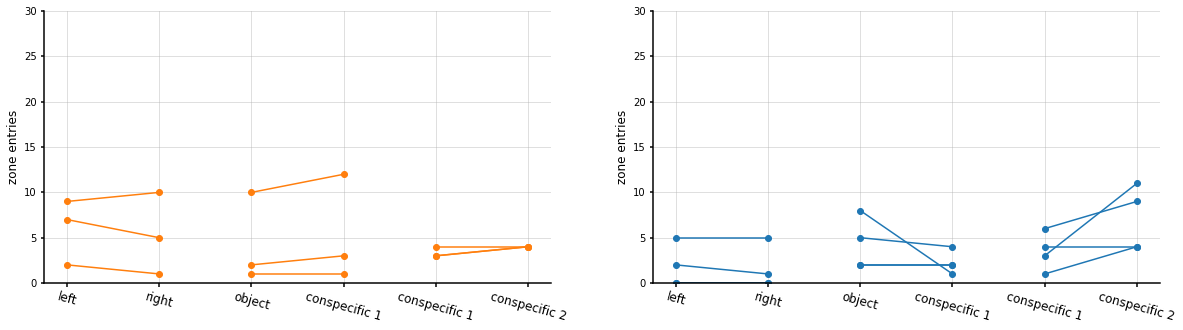

In [51]:
the_cond = 'linear_social_1.5mgkg_rBaclofen'
gtypes = stat_dict.keys()

## plot / test occupancy:
cmap = plt.get_cmap('tab10')
#cdict = dict(zip(gtypes, [cmap(i) for i in np.linspace(0, 1 , len(gtypes))]))
cdict = dict(zip(gtypes, [cmap(i) for i in range(len(gtypes))][::-1]))
tick_dict = {'habituate':(1,1.1), 'preference':(1.2,1.3), 'novelty':(1.4,1.5) }

f,ax = plt.subplots(1, 2, figsize = (20,5))

for the_gtype,a in zip(stat_dict.keys(), ax):
    the_subjs = stat_dict[the_gtype][the_cond].keys()
    for subj in the_subjs: 
        align_points = find_com_entries(stat_dict[the_gtype][the_cond][subj]['COM'], sides)

        for p in phase_dict:
            #print(p, sum([i in np.arange(phase_dict[p][0], phase_dict[p][1]) for i in align_points[sides[0]]['entry frames']]), align_points[sides[1]]['entry frames'] )
            left_entries = sum([i in np.arange(phase_dict[p][0], phase_dict[p][1]) for i in align_points[sides[0]]['entry frames']])
            right_entries = sum([i in np.arange(phase_dict[p][0], phase_dict[p][1]) for i in align_points[sides[1]]['entry frames']])
            if p == 'preference':
                a.plot([tick_dict[p][0], tick_dict[p][1]], [right_entries, left_entries], 'o-', color = cdict[the_gtype])
            elif p == 'novelty':
                a.plot([tick_dict[p][0], tick_dict[p][1]], [left_entries, right_entries], 'o-', color = cdict[the_gtype])
            elif p == 'habituate':
                a.plot([tick_dict[p][0], tick_dict[p][1]], [right_entries, left_entries], 'o-', color = cdict[the_gtype])
            

for a, gtype in zip(ax, gtypes):
    #a.set_title(gtype)
    a.set_xticks([1, 1.1, 1.2, 1.3, 1.4, 1.5])
    a.set_xticklabels(['left', 'right', 'object', 'conspecific 1', 'conspecific 1', 'conspecific 2'], rotation = 345, fontsize=12)
    a.set_ylim(0,30)
    a.set_yticks([0,5,10,15,20,25,30])
    a.set_ylabel('zone entries', fontsize=12)
    a.grid('on', alpha=.5)
    twoaxis(a)
plt.show()


***

In [ ]:
phase_dict = {'habituate':(500,5500), 'preference':(6500,17500), 'novelty':(18500,18500+11500) }
null_phase = 'habituate'
sides = (95,230)
events = ['entry frames']
dat_type = 'trace_mtx'
do_min_subtract = True

In [ ]:
dict_out = dict.fromkeys(phase_dict.keys())
#dicts_out = []

In [ ]:
dict_out

## Primary pooling loop, generates dict_out:

## multiple cond version:

In [ ]:
experiments = ['linear_social_saline', 'linear_social_1.5mgkg_rBaclofen']

In [ ]:
for phase in phase_dict:
    print(phase)
    phase_start = phase_dict[phase][0]
    phase_stop = phase_dict[phase][1]
    aligned_traces_dict = make_aligned_trace_dict_multicond(stat_dict, framewin=phase_dict[phase], exp_list=experiments, x_thresh = sides, win=(20,60)) # event-aligned traces
    for the_cond in stat_dict.keys():
        for the_exp in stat_dict[the_cond].keys():
            print('\t',the_cond, the_exp )
            for the_subj in stat_dict[the_cond][the_exp].keys():
                print(the_subj)
                for the_side in sides:
                    print('\t',the_side)
                    the_null_trace_mtx = stat_dict[the_cond][the_exp][the_subj][dat_type]

                    if len(aligned_traces_dict[the_cond][the_exp][the_subj][the_side]['entry frames']['aligned_mtx'].shape) < 3:
                        aligned_traces_dict[the_cond][the_exp][the_subj][the_side]['entry frames']['modulation'] = []
                        aligned_traces_dict[the_cond][the_exp][the_subj][the_side]['entry frames']['modulation prob'] = []
                        continue
                    num_trials = aligned_traces_dict[the_cond][the_exp][the_subj][the_side]['entry frames']['aligned_mtx'].shape[0]
                    num_cells = aligned_traces_dict[the_cond][the_exp][the_subj][the_side]['entry frames']['aligned_mtx'].shape[2]
                    null_dist = make_modulation_null_dist(the_null_trace_mtx, 20, 60, null_iters=100, 
                                                          p_start = phase_dict[null_phase][0], p_stop = phase_dict[null_phase][1], 
                                                          num_pool = num_trials, min_subtract = do_min_subtract)

                    stat_mtx = np.mean(aligned_traces_dict[the_cond][the_exp][the_subj][the_side]['entry frames']['aligned_mtx'], axis=0)
                    mod_mtx = []
                    for i in range(np.shape(stat_mtx)[1]):
                        if do_min_subtract is True:
                            min_subtracted = (stat_mtx.transpose()[i]) - (np.min(stat_mtx.transpose()[i]))
                        else:
                            min_subtracted = (stat_mtx.transpose()[i])
                        mod_mtx.append(compute_mod_index(min_subtracted))
                    mod_p = np.asarray([prob_from_dist(i,j, hist_range=(0,10)) for i,j in zip(mod_mtx, null_dist)])
                    #print('\t',the_side, aligned_traces_dict[the_cond][the_subj][the_side]['entry frames'].keys())                
                    aligned_traces_dict[the_cond][the_exp][the_subj][the_side]['entry frames']['modulation'] = mod_mtx
                    aligned_traces_dict[the_cond][the_exp][the_subj][the_side]['entry frames']['modulation prob'] = mod_p
                    #print('\t',the_side, aligned_traces_dict[the_cond][the_subj][the_side]['entry frames'].keys())

                    #print('\t',the_side, aligned_traces_dict[the_cond][the_subj][the_side]['entry frames']['modulation prob'])
    #print('\t',the_side, aligned_traces_dict[the_cond][the_exp][the_subj][the_side]['entry frames'].keys())
    dict_out[phase] = aligned_traces_dict
            #dicts_out.append(aligned_traces_dict)
                
                

In [ ]:
dict_out['preference']['FMR1CTRL']['linear_social_saline']['OM047'][95]['entry frames']['modulation prob']

***

In [ ]:
def trace_mtx_event_rate(trace_mtx, baseline_range = [], thresh_coef = 1, rate_thresh_coef= 5, rate_thresh = 0.01):
    '''
    
    
    '''
    
    thresh_mtx = np.zeros_like(trace_mtx)
    
    if len(baseline_range) == 0:
        baseline_range = (0, len(trace_mtx))
    
    for idx, the_trace in enumerate(trace_mtx):
        the_thresh = noise_variance_stabilization(abs(the_trace[baseline_range[0]:baseline_range[1]]))
        thresh_trace = np.copy(the_trace)
        if len(np.argwhere(thresh_trace > (the_thresh * rate_thresh_coef)).flatten()) > (rate_thresh * len(the_trace)):
            thresh_trace[thresh_trace < (the_thresh * thresh_coef)] = np.nan          
        else:
            thresh_trace[:] = np.nan
        thresh_mtx[idx,:] = thresh_trace

        
    
    return np.nansum(thresh_mtx, axis=0) / thresh_mtx.shape[0]